In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig

#sklearn
from sklearn.metrics import classification_report

#NLP libiries
import sklearn as sk
import os
import nltk
from nltk.data import find

#data process
import numpy as np
import matplotlib.pyplot as plt
import re
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
%%capture
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [7]:
#load the dataset
train_df = pd.read_csv('2016_train_data.csv')
test_df = pd.read_csv('2016_test_data.csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [8]:
train_df.head(1)

,title,date,content_original,bias,bias_text,source
0,"trump present dilemma evangelical women, reliable gop voter listen· 3:46",2016-11-01,"trump present dilemma evangelical women, reliable gop voter enlarge image toggle caption frank mullen/gettyimages frank mullen/gettyimages white evangelicals reliable republican voters. also long history demanding politician exemplify character morality public life. so many, republican presidential nominee donald trump present moral dilemma. trump apologized many saw one egregious moment — bragging groping kissing woman without consent 2005 recording. denied allegation several woman accusing sexual assault. but episode exposed another divide white evangelical community — split gender. several prominent male evangelical leader quick accept trump apology comments. called voter stay focused defeating democratic nominee hillary clinton. for evangelical women, like charmaine yoest protrump group american values, trump apology good start. i think situation like really cant overdo talking much understand people feeling — thats part leader, yoest says. for others, like katelyn beaty, editoratlarge christianity today, response evangelical leader exposed lack understanding. every church america woman member sitting pew every sunday deeply personal issue, beaty says. beatys magazine recently published editorial critical trump. speaking via skype, beaty pointed prominent evangelical writer like beth moore jen hatmaker whove recently called male leader quick dismiss whole thing. for many rankandfile women, sexual harassment assault personal issues, say susan fletcher colorado springs. i victim sexual harassment workplace; ive life made living hell person power me, says. fletcher, 30s, staff historian evangelical ministry. say rhetoric shes hearing recently around sexual assault disturbing many evangelical woman knows. you know, traditional, almost patriarchy older, white, evangelical men supporting endorsing — definitely huge disconnect theyre saying people like me, historian young woman, thinking feeling, fletcher says. christian singersongwriter nichole nordeman say usually stay politics, felt compelled speak year. nordeman point men, like southern baptist leader russell moore christian writer max lucado, speaking trump months. call response others devastating. i find sickening men face congregation family college campus feel ok trusting donald trump voice vote country — still somehow explain away lens teaching christ, nordeman says. boggles mind. baffling. nordeman say exciting time evangelical woman, think evangelicalism may turning point. in circle run in, keep hearing term xvangelical thrown around quite bit — sense trying find new language define u follower christ, old term felt unbelievably compromised election old guard evangelical leadership, nordeman says. beaty say there lot stake evangelical old guard address issue gender. they risk losing authority kind trust many evangelicals country, especially evangelical women, beaty says. beaty say rift highlighted politics 2016 likely continue long campaign over.",1,center,NPR Online News


In [9]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (2314, 6)


In [10]:
test_df.head(1)

,title,date,content_original,bias,bias_text,source
0,trump: inner city run democrat dangerous war zone,2016-08-22,"meant give scripted speech rival, republican nominee veered message attempt appeal minority voter apocalyptic term donald trump veered script monday night claim inner city run democrats” dangerous country iraq afghanistan. the republican nominee meant delivering speech calling hillary clinton investigated special prosecutor. however, veered message attempt appeal minority voter apocalyptic terms. you go war zone country fighting safer living inner city run democrats,” trump said. republican nominee also promised elected, we’ll get rid crime. you’ll able walk street without getting shot. now, walk street, get shot.” trump made increased appeal support african american recent days. despite that, recent nbc/wall street journal poll showed trump receiving support 1% african american voters, historically low total. poll margin error plus minus 3.5%. republican nominee repeatedly argued african american voter support past week, saying: got lose?” contrast, new york real estate developer railed called bigotry hillary clinton, see people color vote human being worthy better future.” the intended focus trump’s message monday call special prosecutor investigate clinton’s leadership state department. trump claimed fbi department justice could trusted investigate hillary clinton’s crimes”. fbi july decided pursue criminal charge clinton use unsecured private email server secretary state. however, so, fbi director james comey rebuked clinton extremely careless” way handled emails. hillary clinton email recovered fbi released election day read more in speech, trump also said fighting peaceful regime change country” warned gravely potential election fraud. got go watch. know i’m talking about,” said. trump long made unsubstantiated claim rigged election” warned inperson voter fraud recently campaign stop pennsylvania. however, exhaustive investigation inperson voter fraud united state found 31 case since 2000 1bn ballot cast. trump spoke blue collar city akron, ohio. buckeye state 18 electoral votes, republican ever white house without winning ohio. according data complied real clear politics, clinton trailed single statewide poll ohio since april. however, despite sagging poll number cryptic warning election fraud, trump still confident victory: get feeling we’re going win landslide.”",0,left,The Guardian


In [11]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (579, 6)


In [12]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

validate_text = test_df['content_original'][0:200]
validate_text_labels = test_df['bias'][0:200]

test_text = test_df['content_original'][200:]
test_text_labels = test_df['bias'][200:]


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  2314

size of valid dataset:  200

size of testing dataset:  379

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [13]:
MAX_SEQUENCE_LENGTH = 300

In [14]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = bert_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [15]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncased Configuration Combo 2

In [16]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 512,
                                     dropout=0.3,
                                     attention_probs_dropout_prob = 0.2,
                                     hidden_dropout_prob=0.2,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(pooler_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)

    hidden_2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_2')(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)

    hidden_3 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_3')(hidden_2)
    hidden_3 = tf.keras.layers.Dropout(dropout)(hidden_3)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_3)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [17]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=6)

retrain layers:  ['_11', '_10', '_9', '_8', '_7', '_6']


In [18]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 300)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 300)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 300)]                0         []                            
 tLayer)                                                                                      

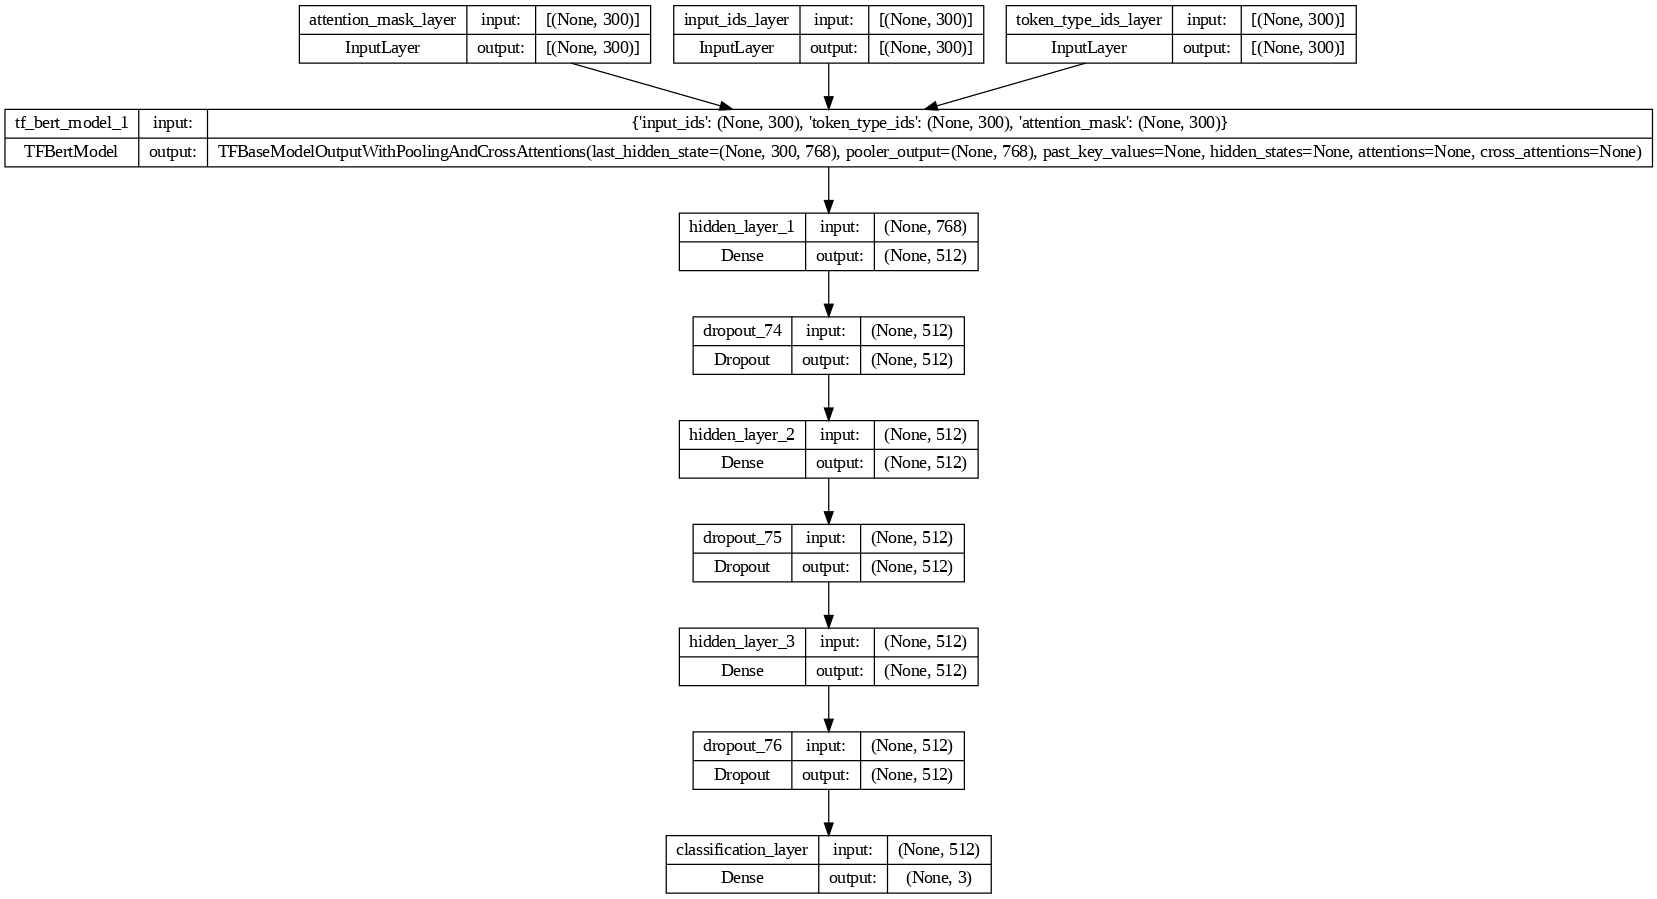

In [19]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [20]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
    batch_size=32,
    epochs=3
)

Epoch 1/3


73/73 [==============================] - 51s 363ms/step - loss: 1.0835 - accuracy: 0.4170 - val_loss: 1.0730 - val_accuracy: 0.4450
Epoch 2/3
73/73 [==============================] - 23s 320ms/step - loss: 1.0594 - accuracy: 0.4291 - val_loss: 0.9206 - val_accuracy: 0.5850
Epoch 3/3
73/73 [==============================] - 23s 320ms/step - loss: 0.7859 - accuracy: 0.6275 - val_loss: 0.5406 - val_accuracy: 0.7550


In [22]:
#eval
score = bert_classification_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                                  y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 2s 156ms/step - loss: 0.6238 - accuracy: 0.7045
Test loss: 0.6237807869911194
Test accuracy: 0.7044854760169983


In [23]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

12/12 [==============================] - 5s 153ms/step


<tf.Tensor: shape=(379,), dtype=int64, numpy=
array([2, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 1,
       1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0,
       1, 0, 0, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 2, 0,
       2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 1, 1,
       2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 1, 2, 1,
       2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 0, 1, 2,
       2, 1, 1, 2, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 0, 0,
       1, 1, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2,
       2, 2, 0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 2, 0,
       2, 0, 0, 2, 1, 1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 1,
       2, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
     

In [24]:
print(classification_report(y_test, predictions_model.numpy()))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75       174
           1       0.62      0.75      0.68        88
           2       0.60      0.77      0.67       117

    accuracy                           0.70       379
   macro avg       0.71      0.72      0.70       379
weighted avg       0.75      0.70      0.71       379



In [27]:
cm = tf.math.confusion_matrix(y_test, predictions_model)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

In [30]:
# import seaborn as sns
# plt.figure(figsize=(20,7))
# sns.heatmap(
#     cm, annot=True,
#     xticklabels=target_names,
#     yticklabels=target_names)
# plt.xlabel("Predicted")
# plt.ylabel("True")